all plots of interest for fitting models of 1-4 layers to data of a 3 layer model.

for each above has no limit on max thickness\
below has a limits of punishish ing the fitting of total thickness > 350 (for the varying slabs)

In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import scipy
import refnx
from refnx.dataset import ReflectDataset, Data1D
from refnx.analysis import Transform, CurveFitter, Objective, Model, Parameter
from refnx.reflect import SLD, Slab, ReflectModel
from sepObjectiveGO import getObjective as gO
from dynesty import DynamicNestedSampler
from dynesty import plotting as dyplot
from DynestyInterface import CFitter
import make_sim_data as msd
print('refnx: %s\nscipy: %s\nnumpy: %s' % (refnx.version.version,
                   scipy.version.version, np.version.version))


refnx: 0.1.16
scipy: 1.5.0
numpy: 1.19.1
refnx: 0.1.16
scipy: 1.5.0
numpy: 1.19.1


In [2]:
def aPlotter(res, interestingNo, spacesize, figI):
    print(figI)
    # no = -1000
    # slc = slice(no-1000,no)
    useAbleLow=0.1
    useAbleHigh=10.
    xall=np.linspace(0,spacesize,len(res["logz"]))
    print("len",len(res["logz"]), "space size", spacesize)
    useable=np.transpose(np.array([[x,y] for y,x in zip(res["logz"],xall) if np.exp(y)>useAbleLow and np.exp(y)<=useAbleHigh]))
    # print(len(res["logz"]),res["logz"][slc])#summary()
    interesting = np.transpose(np.array([[x,y] for y,x in zip(res["logz"],xall) if x>=float(interestingNo)]))#.reshape((2,-2))
#     print("len 2", len(interesting[0]), len(interesting), interesting[0,:3])
    print("logz max: ",max(res["logz"]),",min: ",min(res["logz"]))
    print("z max: ",max(np.exp(res["logz"])),",min: ",min(np.exp(res["logz"])))
#     print(res["logz"][:5],interesting[1,:5],useable[1,:5])
    # print("interesting")
#     xall=np.linspace(0,spacesize,len(res["logz"]))
#     xusable=np.linspace(0,spacesize,len(useable))
    plt.figure(figI)
    figI+=1
    if len(useable)>=2:
        n_plots = 3
    else:
        n_plots = 2
    plt.subplot(1, n_plots, 1)
    plt.plot(xall,res["logz"])
    if any([lnz<=0 for lnz in res["logz"]]):
        plt.title("ln(evidence)\n not log scaled vs -ln(X)")
        plt.plot(xall, [0 for value in xall], label="ln(evidence)=0", alpha=0.4,linestyle="--")
    else:
        plt.title("ln(evidence)\n log scaled vs -ln(X)")
        plt.yscale("log")
    plt.xlabel("-ln(X)")
    plt.ylabel("ln(evidence)")
#     plt.figure(figI)
#     figI+=1
    plt.subplot(1, n_plots, 2)
    plt.plot(interesting[0],interesting[1])
    plt.title("interesting values\n ln(evidence)\n"+r" vs -ln(X) $\geq %d$" % interestingNo)
    plt.xlabel("-ln(X)")
    plt.ylabel("ln(evidence)")
    if len(useable)>=2:
        plt.subplot(1, n_plots, 3)
        plt.plot(useable[0],useable[1])
        plt.title("usful values\n"+r"ln(%.3f<evidence $\leq$ %.3f) vs -ln(X)"%(useAbleLow,useAbleHigh))
        plt.xlabel("-ln(X)")
        plt.ylabel("ln(evidence)")
    else:
        print("not enough 'usable' data points")
    print(figI)
    plt.tight_layout()
    return figI

In [3]:
# def min_interesting_lnX(res):
#     returns = None
# #     returns = min([-lnX for lnX, wt in zip(res["logvol"], np.exp(res['logwt'] - res['logz'][-1])) if wt>0])
#     returns = [(-lnX,wt) for lnX, wt in zip(res["logvol"], np.exp(res['logwt'] - res['logz'][-1])) if wt>0.001]
#     return returns

def min_interesting_lnX(res):
    returns = None
    for lnX, logz in zip(res["logvol"], res['logz']):
        if logz >= 0.:
            break
        else:
            returns = -lnX
#     returns = min([-lnX for lnX, wt in zip(res["logvol"], np.exp(res['logwt'] - res['logz'][-1])) if wt>0])
    return returns

maxLength = 350
def logp_extra(model, data=None):
    returns = 0
    if sum(model.structure.slabs()[1:-1,0])>maxLength:
        returns = -np.inf
    return returns

In [4]:
figI = 0
# simple structure
thicks_true = [10,120,100,130,10]
bs_true = [0,5,4.5,5,10]
roughs_true = [0,0,0,0,0]
# bs = [5,4.5,5]
# thicks = [120,100,130]
# roughs = [0,0,0]
bs = bs_true
thicks = thicks_true
roughs = roughs_true
loss = 1.
no_layers = len(bs)
# no_layers = len(bs_true)
# no_layers = 3
layers1 = []
layers2 = []
names = []
#names = ['layer1','layer2']
contrast_layer = 1
bs_contrast_layer = 6
thicks_contrast_layer=Parameter(thicks[contrast_layer],
                                "layer1 thickness")
roughs_contrast_layer=Parameter(roughs[contrast_layer],
                                "layer0/contrast roughness")
for i in range(no_layers):
    names.append('layer'+str(i))
for i in range(no_layers):
    if i != contrast_layer:
        sld = SLD(bs[i],name=names[i])
        sld = sld(thicks[i],roughs[i])
        layers1.append(sld)
        layers2.append(sld)
    else:
        sld1 = SLD(bs[i],name=names[i]+" contrast a")
        sld1 = sld1(thicks_contrast_layer,roughs_contrast_layer)
        sld2 = SLD(bs_contrast_layer,name=names[i]+" contrast b")
        sld2 = sld2(thicks_contrast_layer,roughs_contrast_layer)
        layers1.append(sld1)
        layers2.append(sld2)

structure1 = layers1[0]
for layer in layers1[1:]:
    structure1|=layer

structure2 = layers2[0]
for layer in layers2[1:]:
    structure2|=layer
print("done")

done


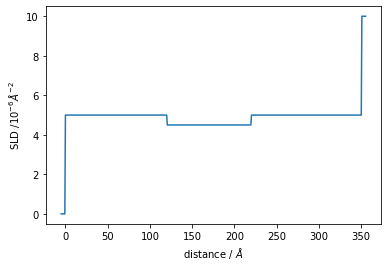

In [5]:
%matplotlib inline
# plt.rcParams['figure.figsize'] = [9.5, 6]
plt.figure(figI)
figI+=1
plt.plot(*structure1.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');

# plt.figure(figI)
# figI+=1
# plt.plot(*structure2.sld_profile())
# plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
# plt.xlabel('distance / $\AA$');
# print("done")

In [6]:
resolution = 5.
model1 = ReflectModel(structure1, bkg=3e-6, dq=resolution)
model2 = ReflectModel(structure2, bkg=3e-6, dq=resolution)

csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


<ErrorbarContainer object of 3 artists>

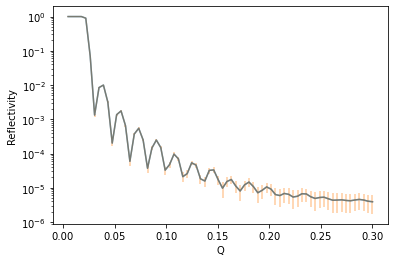

In [7]:
q = np.linspace(0.005, 0.3, 70)# was 1001 no 70
plt.figure(figI)
figI+=1
R1 = model1(q, x_err=resolution)
plt.plot(q, R1)
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.yscale('log')
sim_dR1 = msd.main(sim_q=q,sim_R=R1)*10
plt.errorbar(q,R1,sim_dR1, alpha=0.4)

# q = np.linspace(0.005, 0.3, 70)# was 1001 no 70
# plt.figure(figI)
# figI+=1
# R2 = model2(q, x_err=resolution)
# plt.plot(q, R2)
# plt.xlabel('Q')
# plt.ylabel('Reflectivity')
# plt.yscale('log')
# sim_dR2 = msd.main(sim_q=q,sim_R=R2)*10
# plt.errorbar(q,R2,sim_dR2, alpha=0.4)

In [8]:
data = Data1D(data= (q,R1,sim_dR1))#,Data1D(data= (q,R2,sim_dR2))]

In [9]:
# # from sepObjective import getObjective as gO
# objective = gO(data, 3)
# # from CFitter import CFitter
# # def ex
# fitter = CFitter(objective)
# # from dynesty import DynamicNestedSampler
# DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
# DNSampler.run_nested(dlogz_init=0.01)
# res = DNSampler.results # 07:18 mins


In [10]:
# res.summary()

summary() doesnt seem useable for dynamic sampling.\
MultiEllipsoidSamplerSamples conditioned on the union of multiple (possibly overlapping) ellipsoids used to bound the set of live points.

calculation is taking ln(z) = ln(evidence) and taking the exponent

In [11]:
# fig, ax = objective.plot()
# figI+=1
# plt.figure(figI)
# figI+=1
# plt.plot(*structure.sld_profile())
# plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
# plt.xlabel('distance / $\AA$');

In [12]:
# span = [(0,5000),(0,1.5),(0,0.4),(10**0,10**1)]
# fig, axes = dyplot.runplot(res,span=span, color='black', mark_final_live=False,
#                            logplot=False)
# fig.tight_layout()

In [13]:
# figI = aPlotter(res, 19, 35, figI)

In [14]:
# fig, axes = dyplot.traceplot(res, truths=np.zeros(fitter.nDim()),
#                              show_titles=True, trace_cmap='plasma',
#                              quantiles=None,
#                            logplot=False)
# fig.tight_layout()

## 1 layered

In [15]:
objective1, structure11 = gO(data, 1, both=True, globalObjective=False) # was 06:09 now 0:36
fitter = CFitter(objective1)
DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
DNSampler.run_nested(dlogz_init=0.05) # was 0.01
res11 = DNSampler.results

# objective2, structure21, structure22 = gO(data, 1,
#                  logpExtra=logp_extra, both=True, globalObjective=True)
# fitter = CFitter(objective2)
# DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
# DNSampler.run_nested(dlogz_init=0.05) # was 0.01
# res12 = DNSampler.results

0it [00:00, ?it/s]

[-1. -1.]


C:\Users\John\Documents\programing\project2020\DynestyInterface.py:57: RuntimeWarning: invalid value encountered in double_scalars
  self._bestPost += post*int(post > self._bestPost) - self._bestPost*int(post > self._bestPost)
22870it [06:45, 56.46it/s, batch: 10 | bound: 69 | nc: 3 | ncall: 67319 | eff(%): 33.973 | loglstar: -1811.884 < -1805.358 < -1806.021 | logz: -1818.225 +/-  0.210 | stop:  0.891]    


previous\
21713it [04:36, 78.66it/s, batch: 9 | bound: 66 | nc: 1 | ncall: 64560 | eff(%): 33.632 | loglstar: -1811.602 < -1805.361 < -1805.882 | logz: -1818.340 +/-  0.211 | stop:  0.955]\
pre previous\
25968it [06:09, 70.27it/s, batch: 10 | bound: 81 | nc: 1 | ncall: 75806 | eff(%): 34.256 | loglstar: -44363.849 < -44357.543 < -44357.955 | logz: -44375.162 +/-  0.250 | stop:  0.975] 

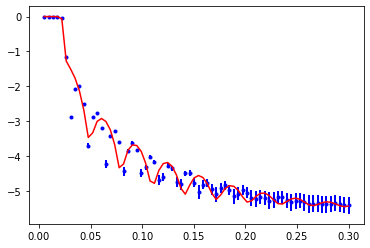

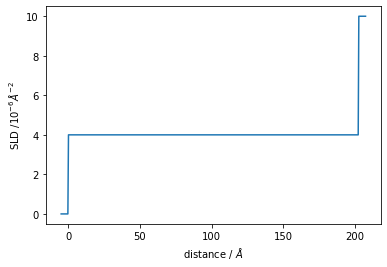

In [16]:
fig, ax = objective1.plot()
figI+=1
plt.figure(figI)
figI+=1
plt.plot(*structure11.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');
# plt.figure(figI)
# figI+=1
# plt.plot(*structure12.sld_profile())
# plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
# plt.xlabel('distance / $\AA$');

# fig, ax = objective2.plot()
# figI+=1
# plt.figure(figI)
# figI+=1
# plt.plot(*structure21.sld_profile())
# plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
# plt.xlabel('distance / $\AA$');
# plt.figure(figI)
# figI+=1
# plt.plot(*structure22.sld_profile())
# plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
# plt.xlabel('distance / $\AA$');

previous failed, fitting two at once

In [17]:
# fig, ax = objective1.plot()
# figI+=1
# plt.figure(figI)
# figI+=1
# plt.plot(*structure11.sld_profile())
# plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
# plt.xlabel('distance / $\AA$');
# plt.figure(figI)
# figI+=1
# plt.plot(*structure12.sld_profile())
# plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
# plt.xlabel('distance / $\AA$');

# fig, ax = objective2.plot()
# figI+=1
# plt.figure(figI)
# figI+=1
# plt.plot(*structure21.sld_profile())
# plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
# plt.xlabel('distance / $\AA$');
# plt.figure(figI)
# figI+=1
# plt.plot(*structure22.sld_profile())
# plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
# plt.xlabel('distance / $\AA$');

In [18]:
# span = [(0,5000),(0,1.5),(0,0.4),(-10**1,10**1)]
# fig, axes = dyplot.runplot(res11,span=span, color='black', mark_final_live=False,
#                            logplot=False)
# fig.tight_layout()

# span = [(0,5000),(0,1.5),(0,0.4),(-10**1,10**1)]
# fig, axes = dyplot.runplot(res12,span=span, color='black', mark_final_live=False,
#                            logplot=False)
# fig.tight_layout()

In [19]:
# print("limit for interesting values from ln(evidence) >= 0")
# figI = aPlotter(res11, min_interesting_lnX(res11), -min(res11["logvol"]), figI)

# figI = aPlotter(res12, min_interesting_lnX(res12), -min(res12["logvol"]), figI)

In [20]:
# print(-min(res11["logvol"]))

In [21]:
# fig, axes = dyplot.traceplot(res11, #truths=np.zeros(fitter.nDim()),
#                              show_titles=True, trace_cmap='plasma',
#                              quantiles=None)
# fig.tight_layout()

# fig, axes = dyplot.traceplot(res12, #truths=np.zeros(fitter.nDim()),
#                              show_titles=True, trace_cmap='plasma',
#                              quantiles=None)
# fig.tight_layout()

## 2 layered

In [22]:
objective2, structure21 = gO(data, 2, both=True, globalObjective=False) # was 06:09 now 0:36
fitter = CFitter(objective2)
DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
DNSampler.run_nested(dlogz_init=0.05) # was 0.01
res21 = DNSampler.results

# objective2, structure21, structure22 = gO(data, 2,
#                  logpExtra=logp_extra, both=True, globalObjective=True)
# fitter = CFitter(objective2)
# DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
# DNSampler.run_nested(dlogz_init=0.05) # was 0.01
# res22 = DNSampler.results


0it [00:00, ?it/s]

[-1. -1. -1. -1.]


C:\Users\John\Documents\programing\project2020\DynestyInterface.py:57: RuntimeWarning: invalid value encountered in double_scalars
  self._bestPost += post*int(post > self._bestPost) - self._bestPost*int(post > self._bestPost)
24483it [07:36, 53.58it/s, batch: 9 | bound: 80 | nc: 5 | ncall: 77001 | eff(%): 31.796 | loglstar: 78.333 < 85.942 < 85.147 | logz: 72.437 +/-  0.204 | stop:  0.956]                


previous\
24152it [05:21, 75.10it/s, batch: 9 | bound: 79 | nc: 2 | ncall: 76847 | eff(%): 31.429 | loglstar: 78.380 < 85.912 < 85.243 | logz: 72.686 +/-  0.202 | stop:  0.836] \
pre previous\
24744it [05:20, 77.20it/s, batch: 8 | bound: 74 | nc: 1 | ncall: 70332 | eff(%): 35.182 | loglstar: 1241.354 < 1247.885 < 1247.372 | logz: 1228.828 +/-  0.255 | stop:  0.951]

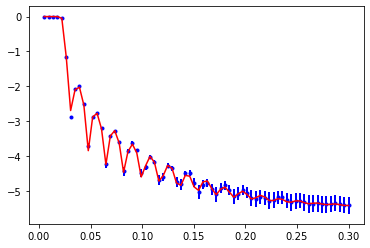

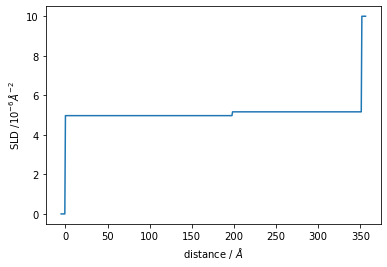

In [23]:
# fig, ax = objective1.plot()
# figI+=1
# plt.figure(figI)
# figI+=1
# plt.plot(*structure11.sld_profile())
# plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
# plt.xlabel('distance / $\AA$');
# plt.figure(figI)
# figI+=1
# plt.plot(*structure12.sld_profile())
# plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
# plt.xlabel('distance / $\AA$');

fig, ax = objective2.plot()
figI+=1
plt.figure(figI)
figI+=1
plt.plot(*structure21.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');
# plt.figure(figI)
# figI+=1
# plt.plot(*structure22.sld_profile())
# plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
# plt.xlabel('distance / $\AA$');

In [24]:
# span = [(0,5000),(0,1.5),(0,0.4),(10**0,10**10)]
# fig, axes = dyplot.runplot(res21,span=span, color='black', mark_final_live=False,
#                            logplot=False)
# fig.tight_layout()

# span = [(0,5000),(0,1.5),(0,0.4),(10**0,10**10)]
# fig, axes = dyplot.runplot(res22,span=span, color='black', mark_final_live=False,
#                            logplot=False)
# fig.tight_layout()

In [25]:
# print(min_interesting_lnX(res22),min_interesting_itr_lnX(res22))

In [26]:
# print("limit for interesting values from ln(evidence) >= 0")

# figI = aPlotter(res21, min_interesting_lnX(res21), -min(res22["logvol"]), figI)

# figI = aPlotter(res22, min_interesting_lnX(res22), -min(res22["logvol"]), figI)

In [27]:
# fig, axes = dyplot.traceplot(res21, #truths=np.zeros(fitter.nDim()),
#                              show_titles=True, trace_cmap='plasma',
#                              quantiles=None)
# fig.tight_layout()

# fig, axes = dyplot.traceplot(res22, #truths=np.zeros(fitter.nDim()),
#                              show_titles=True, trace_cmap='plasma',
#                              quantiles=None)
# fig.tight_layout()

## 3 layered

In [28]:
objective3, structure31 = gO(data, 3, both=True, globalObjective=False) # was 06:09 now 0:36
fitter = CFitter(objective3)
DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
DNSampler.run_nested(dlogz_init=0.05) # was 0.01
res31 = DNSampler.results

# objective2, structure21, structure22 = gO(data, 3,
#                  logpExtra=logp_extra, both=True, globalObjective=True)
# fitter = CFitter(objective2)
# DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
# DNSampler.run_nested(dlogz_init=0.05) # was 0.01
# res32 = DNSampler.results

0it [00:00, ?it/s]

[-1. -1. -1. -1. -1. -1.]


C:\Users\John\Documents\programing\project2020\DynestyInterface.py:57: RuntimeWarning: invalid value encountered in double_scalars
  self._bestPost += post*int(post > self._bestPost) - self._bestPost*int(post > self._bestPost)
27914it [14:46, 31.48it/s, batch: 8 | bound: 184 | nc: 7 | ncall: 168407 | eff(%): 16.575 | loglstar: 100.030 < 108.363 < 108.314 | logz: 91.461 +/-  0.226 | stop:  0.962]           


previous\
28609it [09:55, 48.06it/s, batch: 8 | bound: 189 | nc: 17 | ncall: 192219 | eff(%): 14.884 | loglstar: 100.123 < 108.366 < 108.319 | logz: 91.440 +/-  0.226 | stop:  0.901]\
pre previous\
29853it [08:20, 59.62it/s, batch: 8 | bound: 162 | nc: 5 | ncall: 145942 | eff(%): 20.455 | loglstar: 1542.518 < 1550.310 < 1548.441 | logz: 1525.116 +/-  0.291 | stop:  0.868]

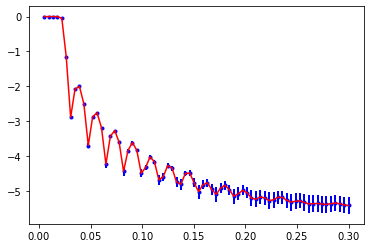

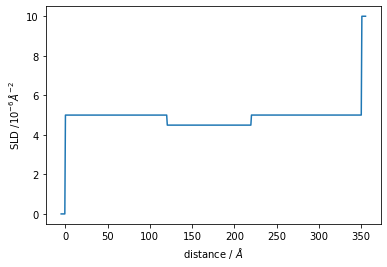

In [29]:
fig, ax = objective3.plot()
figI+=1
plt.figure(figI)
figI+=1
plt.plot(*structure31.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');
# plt.figure(figI)
# figI+=1
# plt.plot(*structure12.sld_profile())
# plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
# plt.xlabel('distance / $\AA$');

# fig, ax = objective2.plot()
# figI+=1
# plt.figure(figI)
# figI+=1
# plt.plot(*structure21.sld_profile())
# plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
# plt.xlabel('distance / $\AA$');
# plt.figure(figI)
# figI+=1
# plt.plot(*structure22.sld_profile())
# plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
# plt.xlabel('distance / $\AA$');

In [30]:
# span = [(0,5000),(0,1.5),(0,0.4),(10**0,10**10)]
# fig, axes = dyplot.runplot(res31,span=span, color='black', mark_final_live=False,
#                            logplot=False)
# fig.tight_layout()

# span = [(0,5000),(0,1.5),(0,0.4),(10**0,10**10)]
# fig, axes = dyplot.runplot(res32,span=span, color='black', mark_final_live=False,
#                            logplot=False)
# fig.tight_layout()

In [31]:
# print("limit for interesting values from ln(evidence) >= 0")

# figI = aPlotter(res31, min_interesting_lnX(res31), -min(res31["logvol"]), figI)

# figI = aPlotter(res32, min_interesting_lnX(res31), -min(res32["logvol"]), figI)

In [32]:
# fig, axes = dyplot.traceplot(res31,# truths=np.zeros(fitter.nDim()),
#                              show_titles=True, trace_cmap='plasma',
#                              quantiles=None)
# fig.tight_layout()

# fig, axes = dyplot.traceplot(res32,# truths=np.zeros(fitter.nDim()),
#                              show_titles=True, trace_cmap='plasma',
#                              quantiles=None)
# fig.tight_layout()

## 4 layered

In [33]:
objective4, structure41 = gO(data, 4, both=True, globalObjective=False) # was 06:09 now 0:36
fitter = CFitter(objective4)
DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
DNSampler.run_nested(dlogz_init=0.05) # was 0.01
res41 = DNSampler.results

# objective2, structure21, structure22 = gO(data, 4,
#                  logpExtra=logp_extra, both=True, globalObjective=True)
# fitter = CFitter(objective2)
# DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
# DNSampler.run_nested(dlogz_init=0.05) # was 0.01
# res42 = DNSampler.results

0it [00:00, ?it/s]

[-1. -1. -1. -1. -1. -1. -1. -1.]


C:\Users\John\Documents\programing\project2020\DynestyInterface.py:57: RuntimeWarning: invalid value encountered in double_scalars
  self._bestPost += post*int(post > self._bestPost) - self._bestPost*int(post > self._bestPost)
20394it [1:26:16,  3.94it/s, batch: 6 | bound: 1068 | nc: 22 | ncall: 1104086 | eff(%):  1.847 | loglstar: 100.340 < 108.123 < 106.814 | logz: 89.756 +/-  0.237 | stop:  0.937]      


previous\
23525it [3:44:24,  1.75it/s, batch: 7 | bound: 6692 | nc: 2 | ncall: 5965849 | eff(%):  0.394 | loglstar: 99.513 < 108.013 < 105.725 | logz: 89.845 +/-  0.233 | stop:  0.930]\
pre previous\
28647it [3:31:10,  2.26it/s, batch: 7 | bound: 4789 | nc: 46 | ncall: 4527187 | eff(%):  0.633 | loglstar: 1542.404 < 1550.302 < 1547.665 | logz: 1522.275 +/-  0.307 | stop:  0.953]  

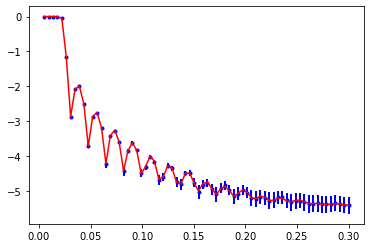

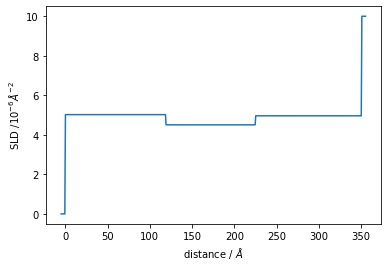

In [34]:
fig, ax = objective4.plot()
figI+=1
plt.figure(figI)
figI+=1
plt.plot(*structure41.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');
# plt.figure(figI)
# figI+=1
# plt.plot(*structure12.sld_profile())
# plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
# plt.xlabel('distance / $\AA$');

# fig, ax = objective2.plot()
# figI+=1
# plt.figure(figI)
# figI+=1
# plt.plot(*structure21.sld_profile())
# plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
# plt.xlabel('distance / $\AA$');
# plt.figure(figI)
# figI+=1
# plt.plot(*structure22.sld_profile())
# plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
# plt.xlabel('distance / $\AA$');

In [35]:
# span = [(0,5000),(0,1.5),(0,0.4),(10**0,10**2)]
# fig, axes = dyplot.runplot(res41,span=span, color='black', mark_final_live=False,
#                            logplot=False)
# fig.tight_layout()

# span = [(0,5000),(0,1.5),(0,0.4),(10**0,10**2)]
# fig, axes = dyplot.runplot(res42,span=span, color='black', mark_final_live=False,
#                            logplot=False)
# fig.tight_layout()

In [36]:
# print("limit for interesting values from ln(evidence) >= 0")

# figI = aPlotter(res41, min_interesting_lnX(res41), -min(res41["logvol"]), figI)

# figI = aPlotter(res42, min_interesting_lnX(res42), -min(res42["logvol"]), figI)

In [37]:
# fig, axes = dyplot.traceplot(res41,# truths=np.zeros(fitter.nDim()),
#                              show_titles=True, trace_cmap='plasma',
#                              quantiles=None)
# fig.tight_layout()

# fig, axes = dyplot.traceplot(res42,# truths=np.zeros(fitter.nDim()),
#                              show_titles=True, trace_cmap='plasma',
#                              quantiles=None)
# fig.tight_layout()

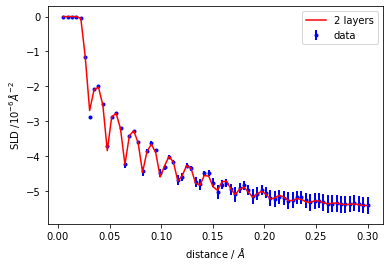

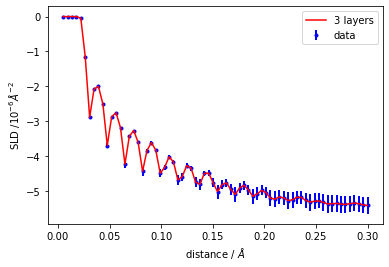

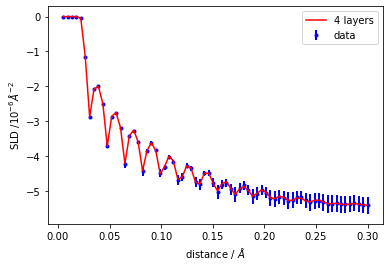

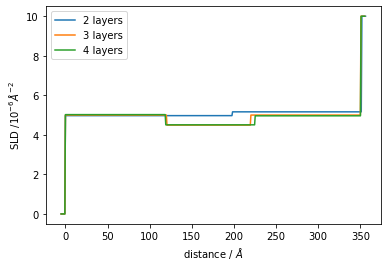

In [38]:
fig, ax = objective2.plot()
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');
plt.legend(["2 layers", "data"])
plt.show()
fig, ax = objective3.plot()#ax)
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');
plt.legend(["3 layers", "data"])
plt.show()
fig, ax = objective4.plot()#ax)
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');
plt.legend(["4 layers", "data"])
plt.show()
# plt.figure(figI)
# figI+=1
plt.plot(*structure21.sld_profile(), label="2 layers")
plt.plot(*structure31.sld_profile(), label="3 layers")
plt.plot(*structure41.sld_profile(), label="4 layers")
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');
plt.legend()
plt.show()